# K-Nearest Neighbors (KNN)

## 1. Import Libraries and Setup

In [10]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, roc_auc_score


## 2. Load Dataset and Prepare Train-Test Split

Split the data into training (80%) and testing (20%) sets with stratification to maintain class distribution.

In [11]:
data = pd.read_csv('churn_data_cleaned.csv')

# split target
X = data.drop(columns=['TARGET'])
y = data['TARGET']

# split data (keep a separate test set BEFORE applying SMOTE!)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## 3. Feature Scaling and Apply SMOTE

Scale features using StandardScaler and apply SMOTE to handle class imbalance. Note: SMOTE is applied to training data only to prevent data leakage.

In [12]:
# SCALE DATA FIRST, before SMOTE
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) # Don't fit on test!

# Apply SMOTE to training set ONLY
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

## 4. Define Hyperparameter Grid

Set up the parameter combinations to test using GridSearchCV. We'll optimize for precision to minimize false positives.

In [21]:
# Import cross-validation tools
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer

print("Setting up hyperparameter grid for KNN")

# Define the parameter grid to search
param_grid = {
    'n_neighbors': [100, 200, 300, 500]
}

print(f"\nTotal combinations to test: {len(param_grid['n_neighbors'])}")

Setting up hyperparameter grid for KNN

Total combinations to test: 4


## 5. Perform 5-Fold Cross-Validation

Train the KNN model using 5-fold cross-validation with grid search to find the best number of neighbors (k).

In [22]:
# Set up 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create base KNN model
knn_base = KNeighborsClassifier()

# Set up GridSearchCV with Precision as the metric
grid_search = GridSearchCV(
    estimator=knn_base,
    param_grid=param_grid,
    cv=cv,
    scoring='precision',
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

# Perform grid search on SMOTE-resampled training data
grid_search.fit(X_train_smote, y_train_smote)

print("Grid search complete.")

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ....................................n_neighbors=100; total time= 1.9min
[CV] END ....................................n_neighbors=100; total time= 1.9min
[CV] END ....................................n_neighbors=100; total time= 1.9min
[CV] END ....................................n_neighbors=100; total time= 1.9min
[CV] END ....................................n_neighbors=100; total time= 1.9min
[CV] END ....................................n_neighbors=200; total time= 2.0min
[CV] END ....................................n_neighbors=200; total time= 2.0min
[CV] END ....................................n_neighbors=200; total time= 2.0min
[CV] END ....................................n_neighbors=200; total time= 2.0min
[CV] END ....................................n_neighbors=200; total time= 2.0min
[CV] END ....................................n_neighbors=300; total time= 2.1min
[CV] END ....................................n_ne

## 6. Display Cross-Validation Results

Show the best parameters found and the top 5 parameter combinations based on precision score.

In [23]:
# Display best parameters and cross-validation results

print("\nBest Parameters Found:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBest Cross-Validation Precision Score: {grid_search.best_score_:.4f}")

# Display top 5 parameter combinations
import numpy as np
cv_results = pd.DataFrame(grid_search.cv_results_)
top_results = cv_results.sort_values('rank_test_score').head(5)[
    ['params', 'mean_test_score', 'std_test_score', 'mean_train_score', 'rank_test_score']
]

print("\nTop 5 Parameter Combinations:")
for idx, row in top_results.iterrows():
    print(f"  Parameters: {row['params']}")
    print(f"  CV Precision Score: {row['mean_test_score']:.4f} (+/- {row['std_test_score']:.4f})")
    print(f"  Train Precision Score: {row['mean_train_score']:.4f}")
    print("\n")


Best Parameters Found:
  n_neighbors: 100

Best Cross-Validation Precision Score: 0.6483

Top 5 Parameter Combinations:
  Parameters: {'n_neighbors': 100}
  CV Precision Score: 0.6483 (+/- 0.0006)
  Train Precision Score: 0.6539


  Parameters: {'n_neighbors': 200}
  CV Precision Score: 0.6316 (+/- 0.0008)
  Train Precision Score: 0.6348


  Parameters: {'n_neighbors': 300}
  CV Precision Score: 0.6262 (+/- 0.0011)
  Train Precision Score: 0.6282


  Parameters: {'n_neighbors': 500}
  CV Precision Score: 0.6217 (+/- 0.0011)
  Train Precision Score: 0.6232




## 7. Evaluate Model Performance

Use the best model from grid search and calculate performance metrics on the test set.

In [24]:
# Train final KNN model with best parameters from cross-validation
knn_final = grid_search.best_estimator_

print(f"\nFinal KNN Model:")
print(f"  n_neighbors: {knn_final.n_neighbors}")

# Predict and evaluate on test set
y_pred = knn_final.predict(X_test_scaled)
y_proba = knn_final.predict_proba(X_test_scaled)[:, 1]

target_names = ['Not Churn', 'Churn']

# Evaluate performance
print("\nKNN Classification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))

from sklearn.metrics import precision_score, recall_score, f1_score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_proba)

print("Performance Metrics")
print(f"Precision:  {precision:.4f}")
print(f"Recall:     {recall:.4f}")
print(f"F1 Score:   {f1:.4f}")
print(f"AUC-ROC:    {auc_roc:.4f}")


Final KNN Model:
  n_neighbors: 100

KNN Classification Report:
              precision    recall  f1-score   support

   Not Churn       0.96      0.53      0.68     65253
       Churn       0.12      0.73      0.21      5785

    accuracy                           0.54     71038
   macro avg       0.54      0.63      0.44     71038
weighted avg       0.89      0.54      0.64     71038

Performance Metrics
Precision:  0.1210
Recall:     0.7340
F1 Score:   0.2078
AUC-ROC:    0.6887


## 8. Visualize Results

Plot confusion matrix and ROC curve to visualize model performance.

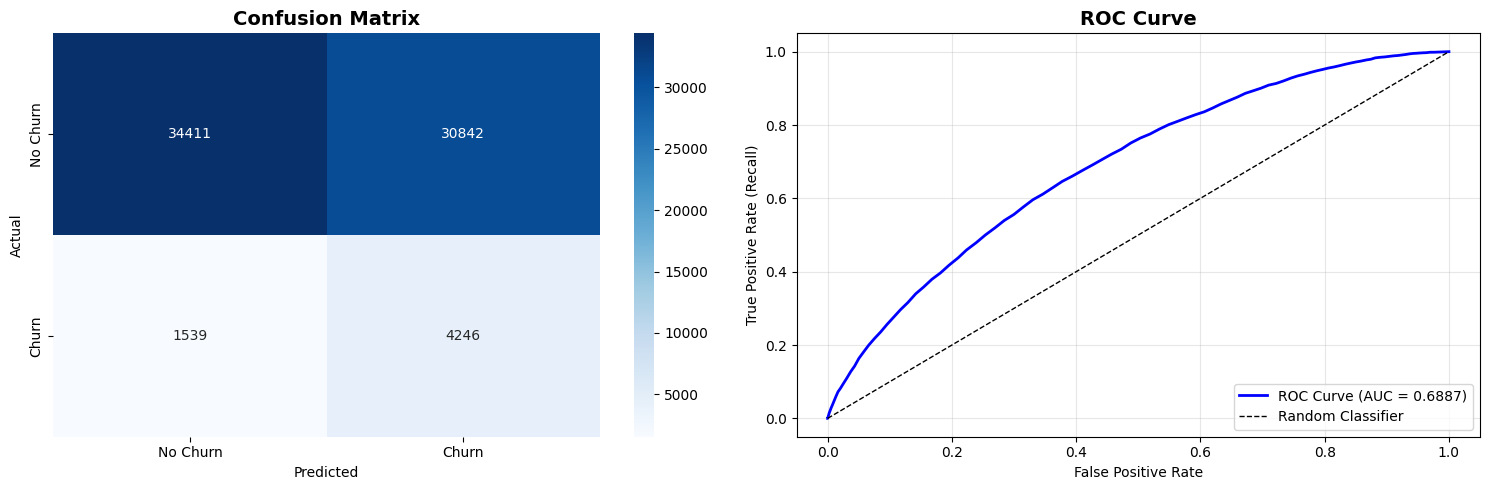

In [25]:
# Plot confusion matrix and ROC curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_xticklabels(['No Churn', 'Churn'])
axes[0].set_yticklabels(['No Churn', 'Churn'])

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
axes[1].plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {auc_roc:.4f})', color='blue')
axes[1].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
axes[1].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate (Recall)')
axes[1].legend(loc='lower right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()